In [35]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import VBMicrolensing as vbm
import scipy.optimize as op
import emcee
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool

Load the data

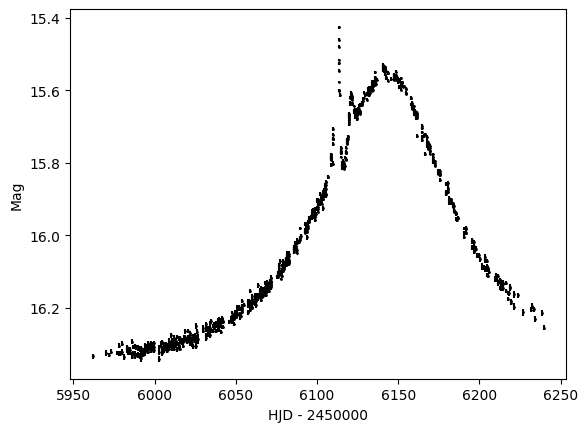

In [21]:

#Load data (row 1 is header)
df = pd.read_csv('2012-BLG-0406_data.txt', sep='\t', header=0)
#load parameters into a dictionary
params = np.loadtxt('2012-BLG-0406_params.txt', unpack=True, skiprows=1, dtype=str)
params_dict = dict(zip(params[0], np.float64(params[1])))
#select only data points where t is in range t0 - 5*tE and t0 + 5*tE
t0i = params_dict['Tmax'] - 2450000
tEi = params_dict['tau']
u0i = params_dict['umin']

df = df[(df['HJD-2450000'] > t0i - 4*tEi) & (df['HJD-2450000'] < t0i + 4*tEi)]

#Plot data
plt.errorbar(df['HJD-2450000'], df['I_Mag'], yerr=df['Err'], fmt='o', color='black', label='data', markersize=1)
plt.xlabel('HJD - 2450000')
plt.ylabel('Mag')
#Invert the y-axis
plt.gca().invert_yaxis()
plt.show()

Convert from magnitudes to fluxes

In [22]:
#Convert from magnitudes to fluxes
def mag2flux(mag: np.ndarray, 
             zp: float = 25.0
             ) -> np.ndarray:
    '''
    Converts magnitude values (array) to flux.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of fluxes.
    '''
    f = 10.0**((mag - zp) / -2.5)
    return f

def mag2flux_err(mag: np.ndarray, mag_err: np.ndarray, 
                 zp: float = 25.0):
    '''
    Converts magnitude values and errors (array) to flux using error propagation formula.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    mag_err : np.ndarray
        Array of magnitude errors.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    flux_err : np.ndarray
        Array of flux errors.
    '''
    dfdmag = -0.4 * np.log(10) * 10.**(0.4*(zp-mag))
    flux_err = np.sqrt(dfdmag**2 * mag_err**2)
    return flux_err

df['I_band_flux'] = mag2flux(df['I_Mag'], 25.0)
df['I_band_flux_err'] = mag2flux_err(df['I_Mag'], df['Err'], 25.0)

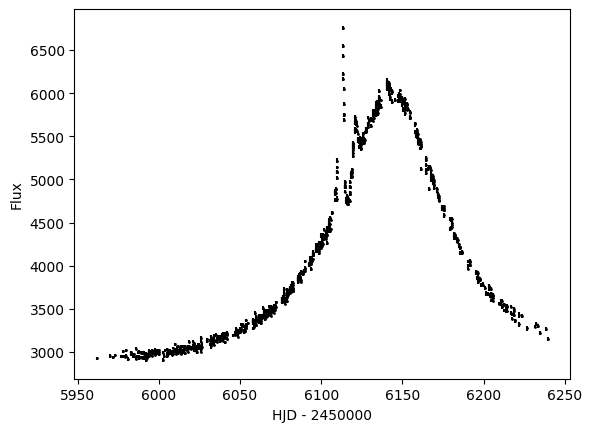

In [23]:
#Plot data
#Plot data
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')

plt.show()

In [33]:
def calc_Fs(modelmag: np.ndarray, f: np.ndarray, sig2: np.ndarray) -> tuple[float, float]:
    '''
    Solves for the flux parameters for a given model using least squares.
    
    Parameters
    ----------
    model : np.ndarray
        Model magnification curve.
    f : np.ndarray
        Observed flux values.
    sig2 : np.ndarray
        Flux errors.
    
    Returns
    -------
    FS : float
        Source flux.
    FB : float
        Blend flux.
    '''
    #A
    A11 = np.sum(modelmag**2 / sig2)
    Adiag = np.sum(modelmag / sig2) 
    A22 = np.sum(1.0 / sig2)
    A = np.array([[A11,Adiag], [Adiag, A22]])
     
    #C
    C1 = np.sum((f * modelmag) / sig2)
    C2 = np.sum(f / sig2)
    C = np.array([C1, C2]).T
     
    #B
    B = np.linalg.solve(A,C)
    FS = float(B[0])
    FB = float(B[1])
    
    return FS, FB

def get_mag(x0, p, t):
    '''
    Get the magnification curve for a given model and parameters.
    
    Parameters
    ----------
    x0: np.ndarray with initial parameters (t0, tE, u0, rho)
    p: list[str] with parameter names
    t: np.ndarray with data epochs
    
    Returns
    -------
    mag: np.ndarray with magnification curve
    '''
     #create a dictionary of parameters
    VBM = vbm.VBMicrolensing()
    params = dict(zip(p, x0))
    paramsc = params.copy()
    tau = (t - paramsc['t0']) / paramsc['tE'] 
    if len(p) < 7 :
        #single lens
        ul = np.sqrt(tau**2 + paramsc['u0']**2)
        if 'logrho' in paramsc.keys():
            paramsc['rho'] = 10**(paramsc['logrho'])
        mag = np.array([VBM.ESPLMag2(u, paramsc['rho']) for u in ul])
    elif len(p) >= 7:
        salpha = np.sin(np.radians(paramsc['alpha']))
        calpha = np.cos(np.radians(paramsc['alpha']))
        y1s = -paramsc['u0'] * salpha + tau * calpha  # source positions - Mulens model alpha convention. Angle between vector joining com to planet and trajectory (measured from binary axis)
        y2s = paramsc['u0'] * calpha + tau * salpha
        y1s = y1s.values
        y2s = y2s.values
        if 'logs' in paramsc.keys():
            paramsc['s'] = 10**(paramsc['logs'])
        if 'logq' in paramsc.keys():
            paramsc['q'] = 10**(paramsc['logq'])
        if 'logrho' in paramsc.keys():
            paramsc['rho'] = 10**(paramsc['logrho'])
        mag = np.array([VBM.BinaryMag2(paramsc['s'], paramsc['q'], y1s[i], y2s[i], paramsc['rho']) for i in range(len(y1s))])
    return mag

def chi2(x0: np.ndarray, p: list, t: np.ndarray, f: np.ndarray, sig: np.ndarray) -> float:
    '''
    Calculates the chi squared value for a given model and parameters.
    
    Parameters
    ----------
    x0 : np.ndarray
        Initial parameters.
    p : List[str]
        List of parameter names.
    t : np.ndarray
        Data epochs.
    f : np.ndarray
        Observed flux values.
    sig : np.ndarray
        Flux errors.
    
    Returns
    -------
    chi2 : float
        Chi squared value.
    '''
    mag = get_mag(x0, p, t)
    FS, FB = calc_Fs(mag, f, sig**2)
    model = FS * mag + FB
    
    chi2_value = np.sum((f - model)**2 / sig**2)

    return chi2_value

def simple_fit(df: pd.DataFrame, x0: np.ndarray, p: list[str], bounds: dict | None = None,
               fixed_params: dict | None = None):
    '''
    Fit a single or binary lens model using downhill simplex method and find $\delta \chi^2$

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with data epochs, flux, and flux errors
    x0 : np.ndarray
        Initial parameters (e.g., t0, tE, u0, rho)
    p : list[str]
        Parameter names corresponding to x0
    bounds : dict | None, optional
        Optional map of parameter name -> (min, max). If None, use defaults.
    fixed_params : dict | None, optional
        Parameters to freeze as {name: value}. Only other parameters are varied.

    Returns
    -------
    fin_params : dict
        Dictionary with final parameters
    fin_chi2 : float
        Final chi-squared value
    delta_chi2 : float
        Delta chi-squared between best fit model and perfect model
    '''
    t = df['HJD-2450000']
    f = df['I_band_flux']
    sig = df['I_band_flux_err']

    # Default bounds
    default_bounds = {
        't0': (t.min(), t.max()),
        'tE': (0.1, 100),
        'u0': (-10.0, 10.0),
        'rho': (1e-5, 1.0),
        's': (1e-2, 20.0),
        'q': (1e-7, 1.0),
        'alpha': (0.0, 360.0),
        'logs': (-2, 2),
        'logq': (-7, 0),
        'logrho': (-5, 0),
    }

    # Merge user bounds with defaults
    bounds_map = default_bounds.copy()
    if bounds is not None:
        bounds_map.update({k: tuple(v) for k, v in bounds.items() if k in bounds_map})

    fixed_params = fixed_params or {}
    fixed_params = {k: float(v) for k, v in fixed_params.items()}

    # Build free/fixed split
    free_param_names = [name for name in p if name not in fixed_params]
    if len(free_param_names) == 0:
        # Nothing to optimize, just evaluate chi2 at fixed x0 values
        fin_params = dict(zip(p, x0))
        # Override with provided fixed values
        fin_params.update(fixed_params)
        x_full = np.array([fin_params[name] for name in p])
        fin_chi2 = chi2(x_full, p, t, f, sig)
        delta_chi2 = fin_chi2 - (len(f) - len(p))
        return fin_params, fin_chi2, delta_chi2

    # Initial free vector in the order of free_param_names
    x0_map = dict(zip(p, x0))
    x0_free = np.array([x0_map[name] for name in free_param_names])

    # Bounds for free parameters
    bounds_free = [bounds_map[name] for name in free_param_names]

    # Objective over free parameters that reconstructs full vector
    def objective(theta_free: np.ndarray) -> float:
        full_map = {**x0_map, **fixed_params}
        for j, name in enumerate(free_param_names):
            full_map[name] = float(theta_free[j])
        x_full = np.array([full_map[name] for name in p])
        return chi2(x_full, p, t, f, sig)

    result = op.minimize(
        objective, x0_free, bounds=bounds_free,
        method='Nelder-Mead', options={'xatol': 1e-8, 'fatol': 1e-8, 'adaptive': False, 'maxfev': 1000}
    )

    if isinstance(result.fun, np.ndarray):
        if result.fun.ndim == 0:
            fin_chi2 = float(result.fun)
        else:
            fin_chi2 = result.fun[0]
    else:
        fin_chi2 = result.fun

    # Reconstruct final full params
    fin_map = {**x0_map, **fixed_params}
    for j, name in enumerate(free_param_names):
        fin_map[name] = float(result.x[j])

    fin_params = {name: fin_map[name] for name in p}
    dof_params = len(free_param_names)
    delta_chi2 = fin_chi2 - (len(f) - dof_params)

    return fin_params, fin_chi2, delta_chi2


def log_prior(x0, p, t, bounds: dict | None = None):
    ''' bounds on parameter
    
    Parameters
    ----------
    x0 : np.ndarray
        Parameter vector (e.g., t0, tE, u0, rho, ...)
    p : list[str]
        Corresponding parameter names
    t : np.ndarray
        Data epochs
    bounds : dict | None, optional
        Optional map of parameter name -> (min, max). If None, use defaults.
    '''

    default_bounds = {'t0': (t.min(), t.max()), 'tE': (0.1, t.max()-t.min()), 'u0': (-10.0, 10.0), 'rho': (1e-5, 1.0), 's': (1e-2, 20.0), 'q': (1e-7, 1.0), 'alpha': (0.0, 360.0), 'logs': (-2, 2), 'logq': (-7, 0), 'logrho': (-5, 0)}
    bounds_map = default_bounds.copy()
    if bounds is not None:
        bounds_map.update({k: tuple(v) for k, v in bounds.items() if k in bounds_map})

    for index, key in enumerate(p):
        lower, upper = bounds_map[key]
        if x0[index] < lower or x0[index] > upper:
            return -np.inf
    return 0.

def log_likelihood(x0, p, t, f, sig):
    '''calculating chi2'''
    ll = -1./2. * chi2(x0, p, t, f, sig)
    return ll

def log_probability(x0, p, t, f, sig, bounds: dict | None = None):
    lp = log_prior(x0, p, t, bounds=bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x0, p, t, f, sig)

def run_mcmc(df, x0, p, steps=500, walkers=100, step_scale=1e-4, 
             param_scales=None, verbose=False, bounds: dict | None = None,
             fixed_params: dict | None = None, pool=None):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with data epochs, flux, and flux errors
    x0 : np.ndarray
        Initial parameters (t0, tE, u0, rho, etc.)
    p : list[str]
        Parameter names
    steps : int, optional
        Number of MCMC steps (default: 500)
    walkers : int, optional
        Number of walkers (default: 100)
    step_scale : float, optional
        Global step size scaling factor (default: 1e-4)
    param_scales : dict[str, float] | np.ndarray | None, optional
        Either dict of per-parameter step sizes or array in p-order.
    verbose : bool, optional
        Print step size information (default: False)
    bounds : dict | None, optional
        Optional map of parameter name -> (min, max). If None, use defaults.
    fixed_params : dict | None, optional
        Parameters to freeze as {name: value}. Only other parameters are sampled.
    pool : multiprocessing.Pool | None, optional
        Multiprocessing pool for parallel evaluation of log probability across walkers.
        If None, runs in serial mode. (default: None)
    
    Returns
    -------
    sampler, pos, prob, state
        MCMC sampler results
    """
    # Take the initial starting point from the event.
    t = df['HJD-2450000']
    f = df['I_band_flux']
    sig = df['I_band_flux_err']

    # Default bounds for clipping initial positions
    default_bounds = {
        't0': (t.min(), t.max()),
        'tE': (0.1, t.max() - t.min()),
        'u0': (-10.0, 10.0),
        'rho': (1e-5, 1.0),
        's': (1e-2, 20.0),
        'q': (1e-7, 1.0),
        'alpha': (0.0, 360.0),
        'logs': (-2, 2),
        'logq': (-7, 0),
        'logrho': (-5, 0),
    }
    bounds_map = default_bounds.copy()
    if bounds is not None:
        bounds_map.update({k: tuple(v) for k, v in bounds.items() if k in bounds_map})

    fixed_params = fixed_params or {}
    fixed_params = {k: float(v) for k, v in fixed_params.items()}

    # free/fixed split
    free_param_names = [name for name in p if name not in fixed_params]
    ndim = len(free_param_names)
    if ndim == 0:
        raise ValueError("No free parameters to sample. Provide some free parameters or omit fixed_params.")

    # Build x0 map and free starting positions
    x0_map = dict(zip(p, x0))
    x0_free = np.array([x0_map[name] for name in free_param_names])

    # Step sizes dict -> array for free params
    if isinstance(param_scales, dict):
        scales_free = np.array([param_scales.get(name, step_scale) for name in free_param_names])
        if verbose:
            print("Using dict step sizes for free parameters:")
            for name, sc in zip(free_param_names, scales_free):
                print(f"  {name}: {sc:.2e}")
    elif isinstance(param_scales, np.ndarray):
        if len(param_scales) != len(p):
            raise ValueError(f"param_scales array must match param_names length ({len(p)}).")
        name_to_scale = dict(zip(p, param_scales))
        scales_free = np.array([name_to_scale[name] for name in free_param_names])
        if verbose:
            print("Using array step sizes mapped to free parameters:")
            for name, sc in zip(free_param_names, scales_free):
                print(f"  {name}: {sc:.2e}")
    elif param_scales is None:
        scales_free = np.array([step_scale] * ndim)
        if verbose:
            print(f"Using global step size: {step_scale:.2e}")
    else:
        raise ValueError("param_scales must be a dict, numpy array, or None")

    # Create initial starting points for all walkers in free space
    nwalkers = walkers
    p0state_free = x0_free + scales_free * np.random.randn(nwalkers, ndim)

    # Clip initial positions to within bounds for free params
    for j, name in enumerate(free_param_names):
        lower, upper = bounds_map.get(name, (-np.inf, np.inf))
        p0state_free[:, j] = np.clip(p0state_free[:, j], lower, upper)

    # Log prob wrapper that reconstructs full vector
    def log_prob_free(theta_free: np.ndarray) -> float:
        full_map = {**x0_map, **fixed_params}
        for j, name in enumerate(free_param_names):
            full_map[name] = float(theta_free[j])
        x_full = np.array([full_map[name] for name in p])
        return log_probability(x_full, p, t, f, sig, bounds)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_free, pool=pool)

    # Run MCMC
    pos, prob, state = sampler.run_mcmc(p0state_free, steps, progress=True)

    return sampler, pos, prob, state, free_param_names

def gelman_rubin_statistic(chains):
    """Calculate Gelman-Rubin R-hat statistic for convergence assessment"""
    n_walkers, n_steps, n_params = chains.shape
    
    if n_steps < 4:
        return np.full(n_params, np.nan)
    
    # Split each chain in half
    half_steps = n_steps // 2
    chains_split = chains[:, -2*half_steps:, :].reshape(2*n_walkers, half_steps, n_params)
    
    r_hat = np.zeros(n_params)
    
    for i in range(n_params):
        chain_means = np.mean(chains_split[:, :, i], axis=1)
        chain_vars = np.var(chains_split[:, :, i], axis=1, ddof=1)
        
        overall_mean = np.mean(chain_means)
        between_var = half_steps * np.var(chain_means, ddof=1)
        within_var = np.mean(chain_vars)
        
        var_estimate = ((half_steps - 1) * within_var + between_var) / half_steps
        r_hat[i] = np.sqrt(var_estimate / within_var) if within_var > 0 else 1.0
    
    return r_hat

def effective_sample_size(chains):
    """Estimate effective sample size"""
    n_walkers, n_steps, n_params = chains.shape
    eff_sizes = np.zeros(n_params)
    
    for i in range(n_params):
        # Flatten chains for this parameter
        flat_chain = chains[:, :, i].flatten()
        
        # Simple autocorrelation-based estimate
        autocorr = np.correlate(flat_chain - np.mean(flat_chain), 
                               flat_chain - np.mean(flat_chain), mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        autocorr = autocorr / autocorr[0]
        
        # Find where autocorr drops below 1/e
        try:
            cutoff = np.where(autocorr < 1/np.e)[0][0]
            eff_sizes[i] = len(flat_chain) / (2 * cutoff + 1)
        except IndexError:
            eff_sizes[i] = len(flat_chain) / 10  # Conservative estimate
    
    return eff_sizes

def plot_corner_mcmc(samples, param_names, title="MCMC Posterior Distributions"):
    """Plot corner plot of MCMC samples"""
    try:
        import corner
    except ImportError:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'corner'])
        import corner
    
    fig = corner.corner(samples, labels=param_names, 
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},
                       label_kwargs={"fontsize": 14})
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    return fig

def plot_mcmc_fit(df, mle_params, param_names, mle_delta_chi2):
    """Plot the best fit model from MCMC"""
    mle_modelmag = get_mag(mle_params, param_names, df['HJD-2450000'])
    source_flux, blend_flux = calc_Fs(mle_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
    mle_model = source_flux * mle_modelmag + blend_flux
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], 
                 fmt='o', color='black', label='Data', markersize=2, alpha=0.7)
    plt.plot(df['HJD-2450000'], mle_model, color='red', linewidth=2, 
             label=f'MCMC Best Fit - $\\Delta \\chi^2 = {mle_delta_chi2:.2f}$')
    plt.xlabel('HJD - 2450000', fontsize=12)
    plt.ylabel('Flux', fontsize=12)
    plt.title('Binary Lens Model - MCMC Fit', fontsize=14)
    plt.legend(loc='upper left', framealpha=0.8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return fig

def plot_mcmc_traces(sampler, param_names, burn_in):
    """Plot MCMC trace plots for convergence diagnosis"""
    fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 2*len(param_names)), sharex=True)
    if len(param_names) == 1:
        axes = [axes]
    
    for i in range(len(param_names)):
        # Plot all walker chains
        for j in range(sampler.chain.shape[0]):
            axes[i].plot(sampler.chain[j, :, i], color='k', alpha=0.4, linewidth=0.5)
        
        # Highlight a few random walkers for clarity
        random_walkers = np.random.choice(sampler.chain.shape[0], size=min(5, sampler.chain.shape[0]), replace=False)
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for idx, walker in enumerate(random_walkers):
            color = colors[idx % len(colors)]
            axes[i].plot(sampler.chain[walker, :, i], color=color, alpha=0.7, linewidth=1.2, 
                        label=f'Walker {walker}' if i == 0 else '')
        
        axes[i].axvline(burn_in, color='red', linestyle='--', linewidth=2, label='Burn-in' if i == 0 else '')
        axes[i].set_ylabel(f'{param_names[i]}', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    axes[-1].set_xlabel('Step Number', fontsize=12)
    plt.suptitle('MCMC Trace Plots - Individual Walker Chains', fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig

def plot_convergence_diagnostics(sampler, param_names, burn_in):
    """Plot running statistics to check convergence"""
    fig, axes = plt.subplots(len(param_names), 2, figsize=(16, 2*len(param_names)))
    if len(param_names) == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(len(param_names)):
        # Calculate running mean and std
        chain_flat = sampler.chain[:, :, i]
        running_mean = np.zeros((chain_flat.shape[0], chain_flat.shape[1]))
        running_std = np.zeros((chain_flat.shape[0], chain_flat.shape[1]))
        
        for walker in range(chain_flat.shape[0]):
            for step in range(1, chain_flat.shape[1]):
                running_mean[walker, step] = np.mean(chain_flat[walker, :step+1])
                running_std[walker, step] = np.std(chain_flat[walker, :step+1])
        
        # Plot running mean
        step_numbers = np.arange(chain_flat.shape[1])
        for walker in range(min(10, chain_flat.shape[0])):
            axes[i, 0].plot(step_numbers, running_mean[walker, :], alpha=0.6, linewidth=1)
        
        axes[i, 0].axvline(burn_in, color='red', linestyle='--', linewidth=2, label='Burn-in')
        axes[i, 0].set_ylabel(f'Running Mean - {param_names[i]}', fontsize=12)
        axes[i, 0].set_title(f'{param_names[i]} - Running Mean Convergence', fontsize=12)
        axes[i, 0].grid(True, alpha=0.3)
        if i == 0:
            axes[i, 0].legend()
        
        # Plot running standard deviation
        for walker in range(min(10, chain_flat.shape[0])):
            axes[i, 1].plot(step_numbers, running_std[walker, :], alpha=0.6, linewidth=1)
        
        axes[i, 1].axvline(burn_in, color='red', linestyle='--', linewidth=2, label='Burn-in')
        axes[i, 1].set_ylabel(f'Running Std - {param_names[i]}', fontsize=12)
        axes[i, 1].set_title(f'{param_names[i]} - Running Std Convergence', fontsize=12)
        axes[i, 1].grid(True, alpha=0.3)
        if i == 0:
            axes[i, 1].legend()
    
    axes[-1, 0].set_xlabel('Step Number', fontsize=12)
    axes[-1, 1].set_xlabel('Step Number', fontsize=12)
    plt.suptitle('MCMC Convergence Diagnostics - Running Statistics', fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig

def perform_mcmc_analysis(df, x0, param_names, steps=3000, walkers=50, 
                         step_scale=1e-4, param_scales=None,
                         verbose=False, plot_corner=False, plot_fit=False, 
                         plot_traces=False, plot_convergence=False, bounds: dict | None = None,
                         fixed_params: dict | None = None, n_threads=None):
    """
    Perform complete MCMC analysis of binary lens model
    
    Parameters
    ----------
    df : pandas.DataFrame
        Data with columns 'HJD-2450000', 'I_band_flux', 'I_band_flux_err'
    x0 : np.ndarray
        Initial parameter values
    param_names : list
        List of parameter names
         steps : int, optional
         Number of MCMC steps (default: 3000)
     walkers : int, optional
         Number of walkers (default: 50)
     step_scale : float, optional
         Global step size scaling factor (default: 1e-4)
     param_scales : dict[str, float] | np.ndarray | None, optional
         Dict step sizes by param name (preferred) or array in p-order.
     verbose : bool, optional
        If True, print detailed diagnostics (default: False)
    plot_corner : bool, optional
        If True, show corner plot (default: False)
    plot_fit : bool, optional
        If True, show best fit model plot (default: False)
    plot_traces : bool, optional
        If True, show trace plots (default: False)
    plot_convergence : bool, optional
        If True, show convergence diagnostics (default: False)
    bounds : dict | None, optional
        Optional map of parameter name -> (min, max). If None, use defaults.
    fixed_params : dict | None, optional
        Parameters to freeze as {name: value}. Only free params are sampled and plotted.
    n_threads : int | None, optional
        Number of parallel threads to use for MCMC. If None, runs in serial mode.
        Uses Python's multiprocessing Pool to parallelize log probability evaluations
        across walkers. (default: None)
    
    Returns
    -------
    results : dict
        Dictionary containing sampler, samples, MLE parameters, statistics, etc.
    """
    
    if verbose:
        print("Running MCMC with binary lens model...")
        print("Initial parameters:", dict(zip(param_names, x0)))
    
    # Create multiprocessing pool if n_threads is specified
    pool = None
    if n_threads is not None:
        pool = Pool(processes=n_threads)
        if verbose:
            print(f"Using {n_threads} parallel processes for MCMC")
    
    try:
        # Run MCMC
        sampler, pos, prob, state, free_param_names = run_mcmc(
            df, x0, param_names, steps=steps, walkers=walkers,
            step_scale=step_scale, param_scales=param_scales, 
            verbose=verbose, bounds=bounds, fixed_params=fixed_params, pool=pool)
    finally:
        # Clean up pool
        if pool is not None:
            #pool.shutdown(wait=True)
            pool.close()
            pool.join()
     
     # Calculate acceptance fraction
    mean_acceptance = np.mean(sampler.acceptance_fraction)
    if verbose:
        print(f"\\nMean acceptance fraction: {mean_acceptance:.3f}")
    
    # Calculate autocorrelation time with error handling
    try:
        autocorr_times = sampler.get_autocorr_time()
        if verbose:
            print(f"Autocorrelation times: {autocorr_times}")
            print(f"Max autocorrelation time: {np.max(autocorr_times):.1f}")
            
            chain_length = sampler.chain.shape[1]
            steps_needed = int(50 * np.max(autocorr_times))
            if chain_length < steps_needed:
                print(f"WARNING: Chain may not be converged. Consider running {steps_needed} steps.")
            else:
                print("Chain length appears adequate for convergence.")
                
    except Exception as e:
        if verbose:
            print(f"Cannot reliably calculate autocorrelation time: {e}")
            print("Using alternative convergence diagnostics...")
        autocorr_times = None
    
    # Determine burn-in period
    if autocorr_times is not None:
        burn_in = min(int(2 * np.max(autocorr_times)), int(0.5 * sampler.chain.shape[1]))
    else:
        burn_in = int(0.3 * sampler.chain.shape[1])
    
    if verbose:
        print(f"Using burn-in period: {burn_in} steps ({burn_in/sampler.chain.shape[1]*100:.1f}% of chain)")
    
    samples = sampler.chain[:, burn_in:, :].reshape((-1, len(free_param_names)))
    
    # Calculate convergence diagnostics
    post_burnin_chains = sampler.chain[:, burn_in:, :]
    r_hat_values = gelman_rubin_statistic(post_burnin_chains)
    eff_sizes = effective_sample_size(post_burnin_chains)
    
    if verbose:
        print(f"\\nGelman-Rubin R-hat statistics (should be < 1.1 for convergence):")
        for i, param in enumerate(free_param_names):
            if not np.isnan(r_hat_values[i]):
                status = "✓ Good" if r_hat_values[i] < 1.1 else "⚠ Poor" if r_hat_values[i] < 1.2 else "✗ Bad"
                print(f"{param}: {r_hat_values[i]:.4f} ({status})")
            else:
                print(f"{param}: Unable to calculate")
        
        print(f"\\nEffective sample sizes:")
        for i, param in enumerate(free_param_names):
            print(f"{param}: {eff_sizes[i]:.0f} (out of {len(samples)} total samples)")
    
    # Find MLE in free space and reconstruct full params
    max_likelihood_idx = np.argmax(sampler.lnprobability[:, burn_in:].flatten())
    mle_free = samples[max_likelihood_idx]
    
    # Reconstruct full parameter vector from free samples
    x0_map = dict(zip(param_names, x0))
    fixed_params_map = fixed_params or {}
    full_map = {**x0_map, **fixed_params_map}
    for j, name in enumerate(free_param_names):
        full_map[name] = float(mle_free[j])
    mle_params = np.array([full_map[name] for name in param_names])
    mle_dict = dict(zip(param_names, mle_params))
    
    # Calculate percentiles on free params only
    percentiles = np.percentile(samples, [16, 50, 84], axis=0)
    medians_free = percentiles[1]
    upper_errors_free = percentiles[2] - percentiles[1]
    lower_errors_free = percentiles[1] - percentiles[0]
    
    # Calculate chi-squared for full MLE
    mle_chi2 = chi2(mle_params, param_names, df['HJD-2450000'], df['I_band_flux'], df['I_band_flux_err'])
    dof_params = len(free_param_names)
    mle_delta_chi2 = mle_chi2 - (len(df) - dof_params)
    
    # Print basic results (always shown)
    print("\\nMaximum Likelihood Estimate (MLE) parameters (full):")
    for param, value in mle_dict.items():
        print(f"{param}: {value:.6f}")
    
    print("\\nMedian values with 1σ uncertainties (free params only):")
    for i, param in enumerate(free_param_names):
        print(f"{param}: {medians_free[i]:.6f} +{upper_errors_free[i]:.6f} -{lower_errors_free[i]:.6f}")
    
    print(f"\\nMLE Chi-squared: {mle_chi2:.2f}")
    print(f"MLE Reduced chi-squared: {mle_chi2/(len(df)-dof_params):.2f}")
    print(f"MLE Delta chi-squared: {mle_delta_chi2:.2f}")
    
    # Assessment and recommendations
    convergence_issues = []
    recommendations = []
    
    if mean_acceptance < 0.2:
        convergence_issues.append("Low acceptance fraction")
        recommendations.append("- Consider decreasing step size in proposal distribution")
    elif mean_acceptance > 0.7:
        convergence_issues.append("High acceptance fraction")
        recommendations.append("- Consider increasing step size in proposal distribution")
    
    if not np.isnan(r_hat_values).all():
        poor_rhat = np.sum((r_hat_values > 1.1) & ~np.isnan(r_hat_values))
        if poor_rhat > 0:
            convergence_issues.append(f"{poor_rhat} parameters have R-hat > 1.1")
            recommendations.append("- Run longer chains for better mixing")
    
    min_eff_size = np.min(eff_sizes)
    if min_eff_size < 100:
        convergence_issues.append("Low effective sample sizes")
        recommendations.append("- Run longer chains to increase effective sample size")
    
    if autocorr_times is not None:
        max_tau = np.max(autocorr_times)
        chain_length = sampler.chain.shape[1]
        if chain_length < 50 * max_tau:
            convergence_issues.append("Chain too short relative to autocorrelation time")
            recommendations.append(f"- Run at least {int(50 * max_tau)} steps for reliable results")
    
    print("\\n" + "="*60)
    print("CONVERGENCE SUMMARY")
    print("="*60)
    
    if convergence_issues:
        print("⚠ POTENTIAL CONVERGENCE ISSUES:")
        for issue in convergence_issues:
            print(f"  • {issue}")
        
    
        print("\\n💡 RECOMMENDATIONS:")
        for rec in recommendations:
            print(f"  {rec}")
    else:
        print("✅ MCMC appears to have converged well!")
    
    print(f"\\n📊 SUMMARY:")
    print(f"  • Total steps: {sampler.chain.shape[1]}")
    print(f"  • Burn-in: {burn_in} steps")
    print(f"  • Effective samples: {len(samples)}")
    print(f"  • Acceptance rate: {mean_acceptance:.3f}")
    if autocorr_times is not None:
        print(f"  • Max autocorr time: {np.max(autocorr_times):.1f}")
    print(f"  • Min effective size: {min_eff_size:.0f}")
    if not np.isnan(r_hat_values).all():
        print(f"  • Max R-hat: {np.nanmax(r_hat_values):.3f}")
    
    print("\\n" + "="*60)
    
    # Generate plots if requested
    if plot_corner:
        plot_corner_mcmc(samples, free_param_names)
    
    if plot_fit:
        plot_mcmc_fit(df, mle_params, param_names, mle_delta_chi2)
    
    if plot_traces:
        plot_mcmc_traces(sampler, free_param_names, burn_in)
    
    if plot_convergence:
        plot_convergence_diagnostics(sampler, free_param_names, burn_in)
    
    # Return results dictionary
    results = {
        'sampler': sampler,
        'samples': samples,  # Free parameter samples only
        'free_param_names': free_param_names,
        'fixed_params': fixed_params_map,
        'mle_params': mle_params,  # Full parameter vector
        'mle_dict': mle_dict,  # Full parameter dict
        'medians': medians_free,  # Free parameter medians
        'upper_errors': upper_errors_free,  # Free parameter upper errors
        'lower_errors': lower_errors_free,  # Free parameter lower errors
        'mle_chi2': mle_chi2,
        'mle_delta_chi2': mle_delta_chi2,
        'burn_in': burn_in,
        'mean_acceptance': mean_acceptance,
        'autocorr_times': autocorr_times,
        'r_hat_values': r_hat_values,
        'eff_sizes': eff_sizes,
        'convergence_issues': convergence_issues,
        'recommendations': recommendations
    }
    
    return results

Fit a single lens model and find $\Delta \chi^2$


Final parameters:  {'t0': 6141.666273271798, 'tE': 54.27628854168735, 'u0': 0.6899690930302913, 'rho': 0.0007415657684320565}
Reduced chi2:  48.63039190028929
Delta chi2:  45248.872305274825


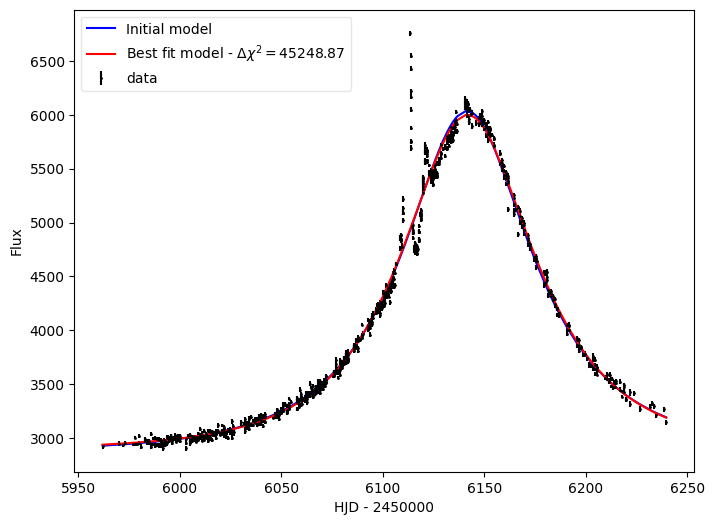

In [7]:

rhoi = 0.001
x0 = np.array([t0i, tEi, u0i, rhoi])
p = ['t0', 'tE', 'u0', 'rho']
init_modelmag = get_mag(x0, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['rho']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()
    

    

Fit a binary lens model from a random guess for binary parameters

1) Using Downhill Simplex

Final parameters:  {'t0': 6141.650214060421, 'tE': 54.35562886553174, 'u0': 0.6880895477354665, 'rho': 0.0006121440385624781, 'logs': -0.16323083406731098, 'logq': -5.1241267206606125, 'alpha': 284.83419074303697, 's': 0.6867033498098312, 'q': 7.514036136467587e-06}
Reduced chi2:  48.733497136836256
Delta chi2:  45203.621788583936


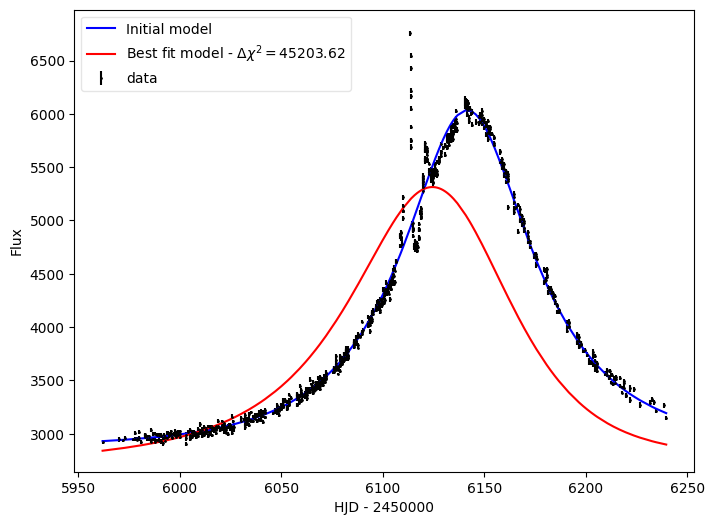

In [50]:
rhoi = 0.001
logsi = np.random.uniform(-2, 1)
logqi = np.random.uniform(-5, 0)
alphai = np.random.uniform(0.0, 360.0)

x0 = np.array([t0i, tEi, u0i, rhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'rho', 'logs', 'logq', 'alpha']
init_modelmag = get_mag(x0, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
fin_params['s'] = 10**(fin_params['logs'])
fin_params['q'] = 10**(fin_params['logq'])
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['rho'], fin_params['s'], fin_params['q'], fin_params['alpha']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()

2) Using MCMC 

In [37]:
# Set random seed for reproducibility 
np.random.seed(42)

# Set up initial parameters for binary lens model
rhoi = 0.001
logsi = np.random.uniform(-2, 1)
logqi = np.random.uniform(-5, 0)
alphai = np.random.uniform(0.0, 360.0)

x0 = np.array([t0i, tEi, u0i, rhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'rho', 'logs', 'logq', 'alpha']

# Run MCMC analysis with all plots enabled
results = perform_mcmc_analysis(df, x0, p, steps=1000, walkers=50,
                            verbose=True, plot_corner=True, plot_fit=True, 
                            plot_traces=True, plot_convergence=False)


You must install the tqdm library to use progress indicators with emcee


Running MCMC with binary lens model...
Initial parameters: {'t0': 6141.413000000175, 'tE': 64.649, 'u0': 0.525, 'rho': 0.001, 'logs': -0.8763796434579125, 'logq': -0.24642846795041917, 'alpha': 263.51781905210584}
Using global step size: 1.00e-04
emcee: Exception while calling your likelihood function:
  params: [ 6.14147370e+03  6.45975344e+01  5.36831803e-01  6.77212526e-02
 -8.37231892e-01 -2.37983672e-01  2.63490208e+02]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/murlidhar.4/miniconda3/envs/microlens/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_56328/3859429863.py", line 362, in log_prob_free
    return log_probability(x_full, p, t, f, sig, bounds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_56328/3859429863.py", line 250, in log_probability
    return lp + log_likelihood(x0, p, t, f, sig)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_56328/3859429863.py", line 243, in log_likelihood
    ll = -1./2. * chi2(x0, p, t, f, sig)
                  ^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_56328/3859429863.py", line 102, i

KeyboardInterrupt: 

Fit a binary lens model from an informed guess

1. Using downhill simplex

Final parameters:  {'t0': 6141.830851678626, 'tE': 71.9296841571558, 'u0': 0.45939138749384184, 'logrho': -1.5082461559849527, 'logs': 0.12915202265644926, 'logq': -3.381687285159853, 'alpha': 227.47385332808386, 's': 1.3463315483464005, 'q': 0.0004152529389399032, 'rho': 0.031028004375475402}
Reduced chi2:  18.8414005517178
Delta chi2:  16895.806322476757


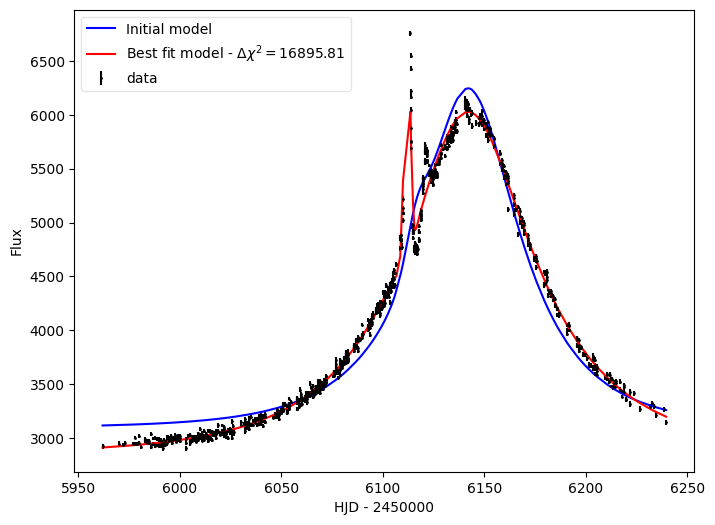

In [21]:
t0i = 6141.380
u0i = 0.545
tEi = 48.600
logrhoi = -1.344
logsi = 0.257
logqi = -2.211
alphai = 180 + np.degrees(0.829)

x0 = np.array([t0i, tEi, u0i, logrhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']
init_modelmag = get_mag(x0, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
fin_params['s'] = 10**(fin_params['logs'])
fin_params['q'] = 10**(fin_params['logq'])
fin_params['rho'] = 10**(fin_params['logrho'])
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['logrho'], fin_params['logs'], fin_params['logq'], fin_params['alpha']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()

2. Using MCMC

\nMaximum Likelihood Estimate (MLE) parameters:
t0: 6141.161494
tE: 63.012382
u0: 0.552496
logrho: -3.880679
logs: 0.159649
logq: -2.887470
alpha: 231.312833
\nMedian values with 1σ uncertainties:
t0: 6141.165772 +0.067661 -0.028534
tE: 62.281303 +0.724959 -10.738125
u0: 0.561853 +0.180325 -0.009436
logrho: -2.777289 +0.753668 -1.370236
logs: 0.161679 +0.032131 -0.002170
logq: -2.887131 +0.007833 -0.042446
alpha: 231.394771 +1.129177 -0.132572
\nMLE Chi-squared: 13005.81
MLE Reduced chi-squared: 13.73
MLE Delta chi-squared: 12058.81
\n============================================================
CONVERGENCE SUMMARY
⚠ POTENTIAL CONVERGENCE ISSUES:
  • 7 parameters have R-hat > 1.1
  • Low effective sample sizes
\n📊 SUMMARY:
  • Total steps: 5000
  • Burn-in: 1500 steps
  • Effective samples: 175000
  • Acceptance rate: 0.233
  • Min effective size: 41
  • Max R-hat: 43.203
\n============================================================


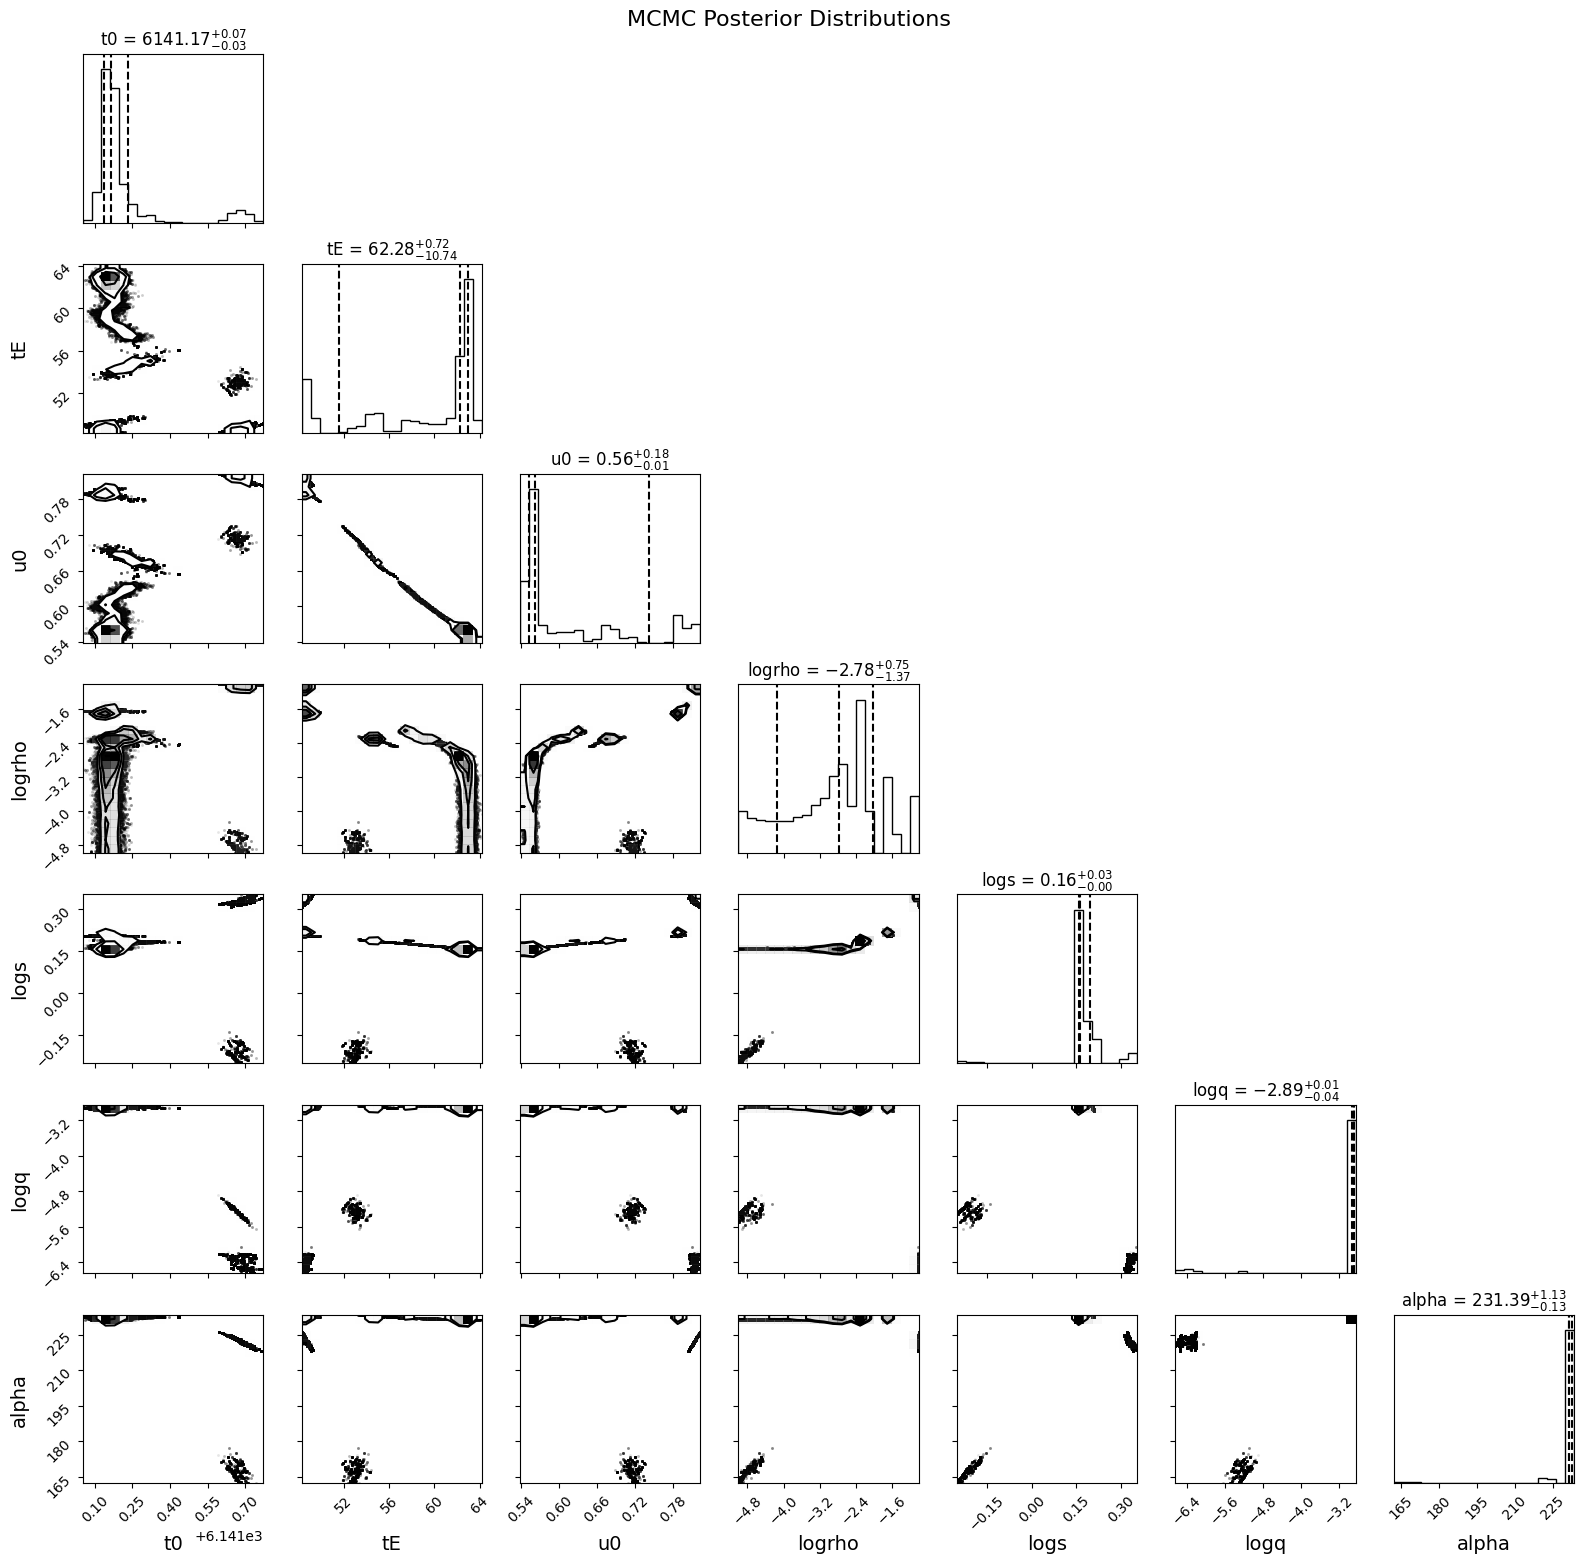

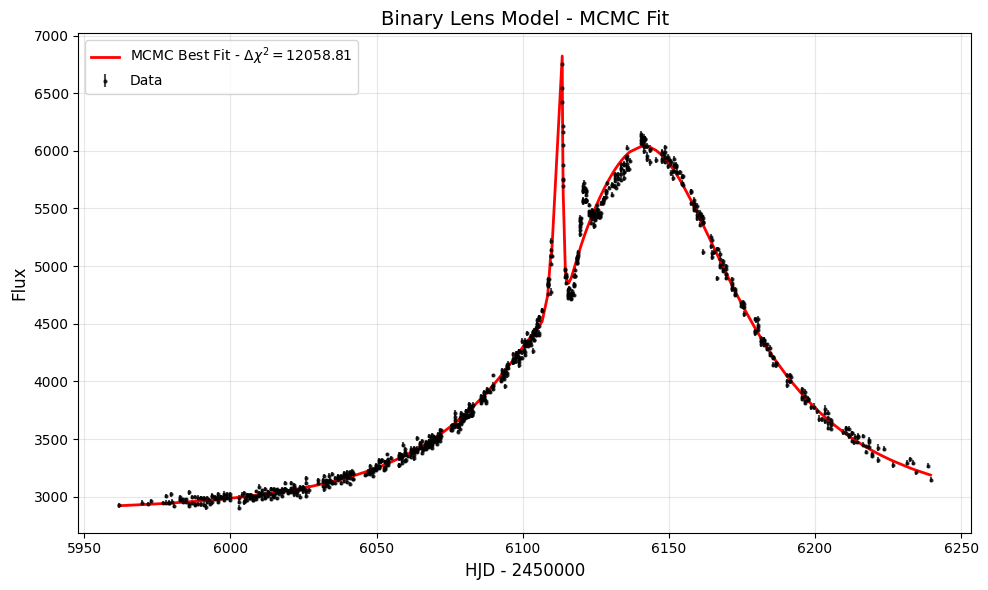

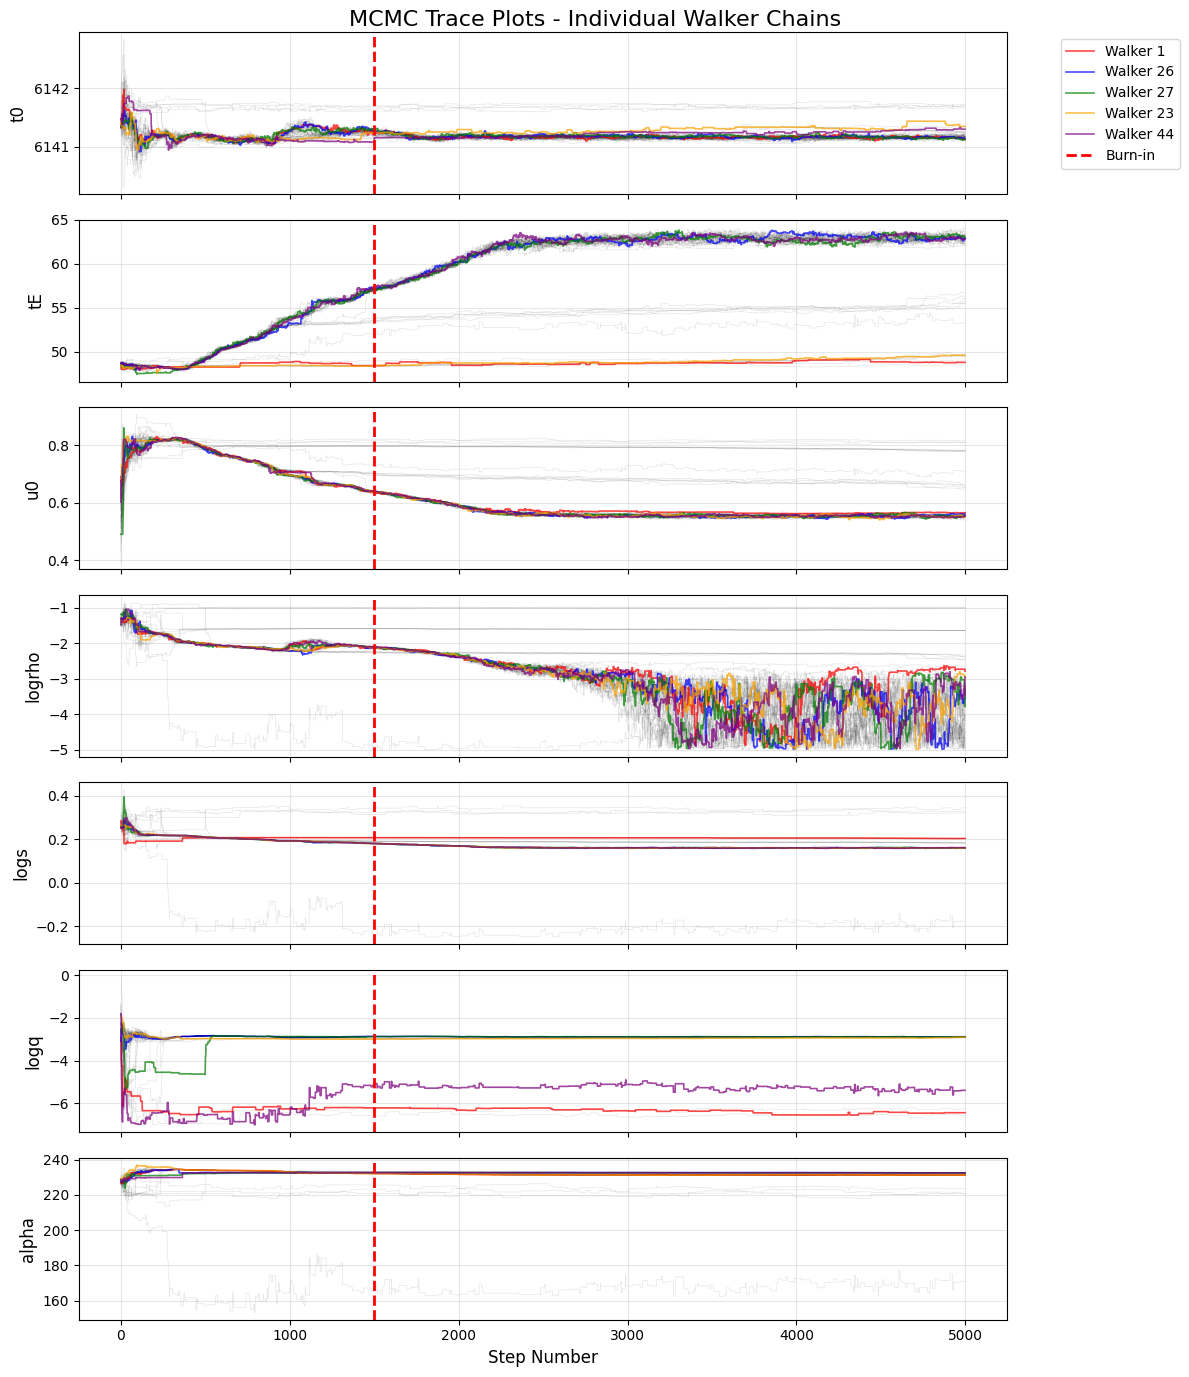

In [23]:
# Set random seed for reproducibility 
np.random.seed(46)

# Set up initial parameters for binary lens model
t0i = 6141.380
u0i = 0.545
tEi = 48.600
logrhoi = -1.344
logsi = 0.257
logqi = -2.211
alphai = 180 + np.degrees(0.829)

x0 = np.array([t0i, tEi, u0i, logrhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']

# Run MCMC analysis with all plots enabled
results = perform_mcmc_analysis(df, x0, p, steps=5000, walkers=50, param_scales=np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-2, 5e-1, 1.0]),
                               verbose=False, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False)

Grid Search 

1. Grid search without magnification maps

In [14]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp

def _process_sq_point(args):
    """
    Worker function: Process single (logs, logq) point - loop through all alpha values.
    Used with ThreadPoolExecutor for notebook compatibility.
    """
    (i, j, logs_val, logq_val, alpha_vals, t0_init, u0_init, 
     tE_init, logrho_init, df, bounds) = args
    
    min_delta_chi2 = np.inf
    best_alpha = None
    best_params = None
    
    for alpha_val in alpha_vals:
        x0 = np.array([t0_init, tE_init, u0_init, logrho_init, 
              logs_val, logq_val, alpha_val])
        p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']
        
        fixed_params = {'logs': logs_val, 'logq': logq_val, 
                       'alpha': alpha_val}
        
        fin_params, fin_chi2, delta_chi2 = simple_fit(
            df, x0, p, bounds=bounds, fixed_params=fixed_params)
        
        if delta_chi2 < min_delta_chi2:
            min_delta_chi2 = delta_chi2
            best_alpha = alpha_val
            best_params = fin_params
    
    return (i, j, min_delta_chi2, best_alpha, best_params)

def grid_search_binary(df, logs_vals, logq_vals, alpha_vals, 
                       t0_init, u0_init, tE_init, logrho_init,
                       bounds=None, n_workers=None, verbose=False):
    """
    Perform grid search over binary lens parameters (logs, logq, alpha).
    
    For each (logs, logq) point on the grid, this function:
    1. Loops through all alpha values
    2. Optimizes t0, u0, tE, logrho using simple_fit with fixed binary params
    3. Selects the alpha value that gives the minimum delta_chi2
    4. Stores the best result for that (logs, logq) point
    
    Parallelizes over (s,q) grid points using threads (notebook-compatible).
    
    Parameters
    ----------
    df : pd.DataFrame
        Data with 'HJD-2450000', 'I_band_flux', 'I_band_flux_err'
    logs_vals : array-like
        Grid values for log10(s)
    logq_vals : array-like  
        Grid values for log10(q)
    alpha_vals : array-like
        Grid values for alpha (degrees)
    t0_init, u0_init, tE_init, logrho_init : float
        Initial values for optimization at each grid point
    bounds : dict, optional
        Parameter bounds for simple_fit
    n_workers : int, optional
        Number of parallel workers to use. If None, uses all available CPU cores.
    verbose : bool, optional
        Print progress information
    
    Returns
    -------
    results : dict
        Contains:
        - 'logs_vals': 1D array of logs values
        - 'logq_vals': 1D array of logq values  
        - 'delta_chi2_grid': 2D array of minimum delta_chi2 for each (logs,logq)
        - 'best_alpha_grid': 2D array of best alpha for each (logs,logq)
        - 'best_params_grid': 2D array of dicts with all best-fit params
        - 'sorted_results': List of dicts sorted by delta_chi2 (ascending)
        - 'fig': matplotlib figure with visualization
    """
    
    # Initialize storage arrays
    delta_chi2_grid = np.zeros((len(logq_vals), len(logs_vals)))
    best_alpha_grid = np.zeros((len(logq_vals), len(logs_vals)))
    best_params_grid = np.empty((len(logq_vals), len(logs_vals)), dtype=object)
    
    # Create list of tasks (one per s,q point)
    tasks = []
    for i, logs_val in enumerate(logs_vals):
        for j, logq_val in enumerate(logq_vals):
            task = (i, j, logs_val, logq_val, alpha_vals, 
                    t0_init, u0_init, tE_init, logrho_init, df, bounds)
            tasks.append(task)
    
    # Determine number of workers (threads for notebook compatibility)
    if n_workers is None:
        n_workers = mp.cpu_count()
    if verbose:
        print(f"Using {n_workers} parallel threads (out of {mp.cpu_count()} available CPU cores)")
        print(f"Processing {len(tasks)} grid points...")
    
    # Execute in parallel with progress tracking
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(_process_sq_point, task): task 
                   for task in tasks}
        
        completed = 0
        for future in as_completed(futures):
            i, j, min_delta_chi2, best_alpha, best_params = future.result()
            delta_chi2_grid[j, i] = min_delta_chi2
            best_alpha_grid[j, i] = best_alpha
            best_params_grid[j, i] = best_params
            
            completed += 1
            if verbose and completed % 10 == 0:
                print(f"Completed {completed}/{len(tasks)} grid points")
    
    if verbose:
        print(f"Grid search complete! Processed {len(tasks)} points.")
    
    # Create meshgrids for plotting
    logs_grid, logq_grid = np.meshgrid(logs_vals, logq_vals)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use pcolormesh for 2D grid visualization
    im = ax.pcolormesh(logs_grid, logq_grid, np.log10(delta_chi2_grid),
                       cmap='viridis', shading='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('$log_{10}(\\Delta \\chi^2)$', fontsize=14)
    
    ax.set_xlabel('log10(s)', fontsize=14)
    ax.set_ylabel('log10(q)', fontsize=14)
    ax.set_title('Grid Search: Binary Lens Parameters', fontsize=16)
    
    # Mark the global minimum
    min_idx = np.unravel_index(np.argmin(delta_chi2_grid), 
                               delta_chi2_grid.shape)
    ax.plot(logs_grid[min_idx], logq_grid[min_idx], 
            'r*', markersize=20, label='Global minimum')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create sorted list of all results
    sorted_results = []
    for i in range(len(logs_vals)):
        for j in range(len(logq_vals)):
            sorted_results.append({
                'logs': logs_vals[i],
                'logq': logq_vals[j],
                's': 10**logs_vals[i],
                'q': 10**logq_vals[j],
                'best_alpha': best_alpha_grid[j, i],
                'delta_chi2': delta_chi2_grid[j, i],
                'all_params': best_params_grid[j, i]
            })
    
    # Sort by delta_chi2 (ascending)
    sorted_results = sorted(sorted_results, key=lambda x: x['delta_chi2'])
    
    return {
        'logs_vals': logs_vals,
        'logq_vals': logq_vals,
        'delta_chi2_grid': delta_chi2_grid,
        'best_alpha_grid': best_alpha_grid,
        'best_params_grid': best_params_grid,
        'sorted_results': sorted_results,
        'fig': fig
    }

Using 8 parallel threads (out of 10 available CPU cores)
Processing 150 grid points...
Completed 10/150 grid points
Completed 20/150 grid points
Completed 30/150 grid points
Completed 40/150 grid points
Completed 50/150 grid points
Completed 60/150 grid points
Completed 70/150 grid points
Completed 80/150 grid points
Completed 90/150 grid points
Completed 100/150 grid points
Completed 110/150 grid points
Completed 120/150 grid points
Completed 130/150 grid points
Completed 140/150 grid points
Completed 150/150 grid points
Grid search complete! Processed 150 points.


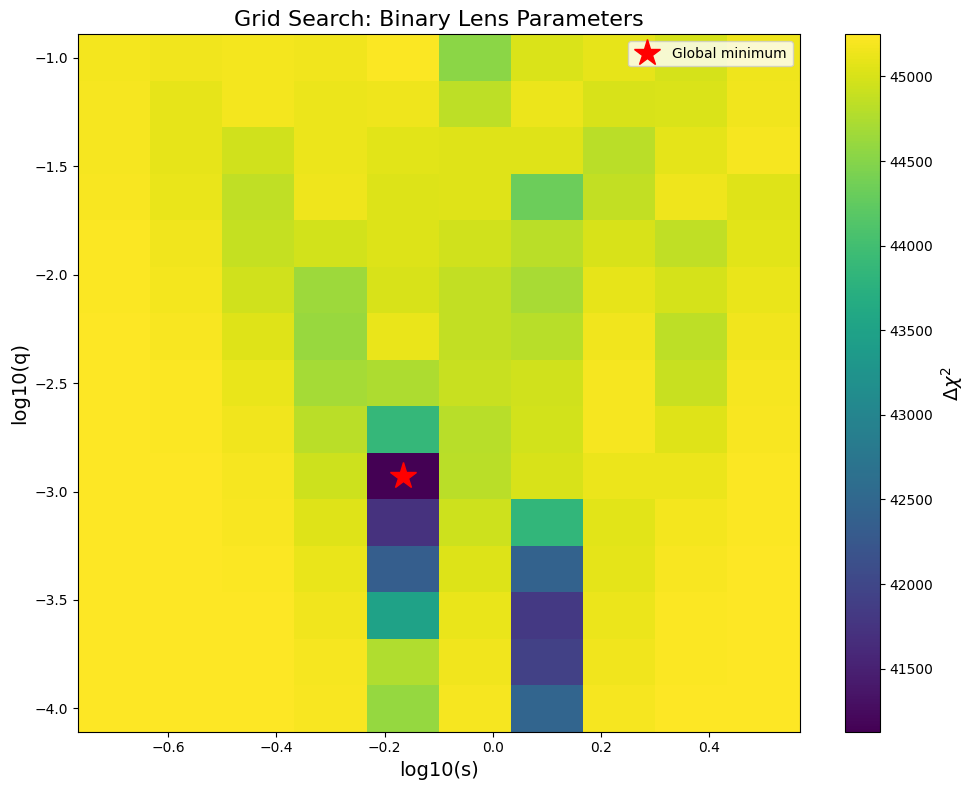


GRID SEARCH RESULTS

Global minimum delta_chi2: 41126.94

Top 5 Best Solutions (sorted by delta_chi2):
------------------------------------------------------------

Rank 1:
  logs = -0.167  (s = 0.681)
  logq = -2.929  (q = 0.001179)
  alpha = 40.0 deg
  delta_chi2 = 41126.94
  All params: {'t0': 6141.792643919502, 'tE': 55.34077121750161, 'u0': 0.676364631617973, 'logrho': -0.9020694919573844, 'logs': -0.16666666666666663, 'logq': -2.928571428571429, 'alpha': 40.0}

Rank 2:
  logs = -0.167  (s = 0.681)
  logq = -3.143  (q = 0.000720)
  alpha = 40.0 deg
  delta_chi2 = 41716.09
  All params: {'t0': 6141.775488597899, 'tE': 56.05448792553097, 'u0': 0.6566808451845435, 'logrho': -0.8937684920775457, 'logs': -0.16666666666666663, 'logq': -3.142857142857143, 'alpha': 40.0}

Rank 3:
  logs = 0.100  (s = 1.259)
  logq = -3.571  (q = 0.000268)
  alpha = 240.0 deg
  delta_chi2 = 41803.82
  All params: {'t0': 6141.608116079519, 'tE': 68.69556460726359, 'u0': 0.5059929031753843, 'logrho': -3.719

In [9]:
# Example usage: Grid search over binary lens parameters

# Define grid ranges
logs_vals = np.linspace(-0.7, 0.5, 10)  
logq_vals = np.linspace(-4, -1, 15)  
alpha_vals = np.linspace(0, 360, 10)  

# Initial values for optimization (from best fit single lens model)
t0_init = 6141.7
u0_init = 0.689
tE_init = 54.276
logrho_init = np.log10(0.00085)

# Run grid search with parallelization
# Set n_workers to limit CPU usage (e.g., n_workers=4 to use 4 cores)
# Leave as None to use all available cores
results = grid_search_binary(
    df, logs_vals, logq_vals, alpha_vals,
    t0_init, u0_init, tE_init, logrho_init, 
    bounds={'u0': (-4, 4), 'logrho': (-4, -0.5)},
    n_workers=8,  # Use 4 cores (change to None to use all available cores)
    verbose=True
)

# Access the best results
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nGlobal minimum delta_chi2: {np.min(results['delta_chi2_grid']):.2f}")

# Top 5 best solutions
print("\nTop 5 Best Solutions (sorted by delta_chi2):")
print("-" * 60)
for i, res in enumerate(results['sorted_results'][:5]):
    print(f"\nRank {i+1}:")
    print(f"  logs = {res['logs']:.3f}  (s = {res['s']:.3f})")
    print(f"  logq = {res['logq']:.3f}  (q = {res['q']:.6f})")
    print(f"  alpha = {res['best_alpha']:.1f} deg")
    print(f"  delta_chi2 = {res['delta_chi2']:.2f}")
    print(f"  All params: {res['all_params']}")

# Access the global best solution
best = results['sorted_results'][0]
print("\n" + "="*60)
print("BEST FIT PARAMETERS")
print("="*60)
print(f"s = {best['s']:.4f}")
print(f"q = {best['q']:.6f}")
print(f"alpha = {best['best_alpha']:.2f} degrees")
print(f"t0 = {best['all_params']['t0']:.6f}")
print(f"tE = {best['all_params']['tE']:.6f}")
print(f"u0 = {best['all_params']['u0']:.6f}")
print(f"rho = {10**best['all_params']['logrho']:.6f}")
print(f"Delta chi2 = {best['delta_chi2']:.2f}")


You must install the tqdm library to use progress indicators with emcee


\nMaximum Likelihood Estimate (MLE) parameters (full):
t0: 6141.786423
tE: 52.408192
u0: 0.748371
logrho: -1.130782
logs: -0.191262
logq: -3.068736
alpha: 45.633271
\nMedian values with 1σ uncertainties (free params only):
t0: 6141.771295 +0.028535 -0.026660
tE: 56.131590 +0.604887 -3.727228
u0: 0.675763 +0.071953 -0.010489
logrho: -1.202718 +0.069323 -0.008836
logs: -0.176692 +0.002286 -0.014537
logq: -3.122136 +0.048039 -0.014975
alpha: 45.338592 +0.342421 -0.207964
\nMLE Chi-squared: 39276.37
MLE Reduced chi-squared: 41.47
MLE Delta chi-squared: 38329.37
\n============================================================
CONVERGENCE SUMMARY
⚠ POTENTIAL CONVERGENCE ISSUES:
  • Low acceptance fraction
  • 7 parameters have R-hat > 1.1
  • Low effective sample sizes
\n💡 RECOMMENDATIONS:
  - Consider decreasing step size in proposal distribution
  - Run longer chains for better mixing
  - Run longer chains to increase effective sample size
\n📊 SUMMARY:
  • Total steps: 5000
  • Burn-in: 1500

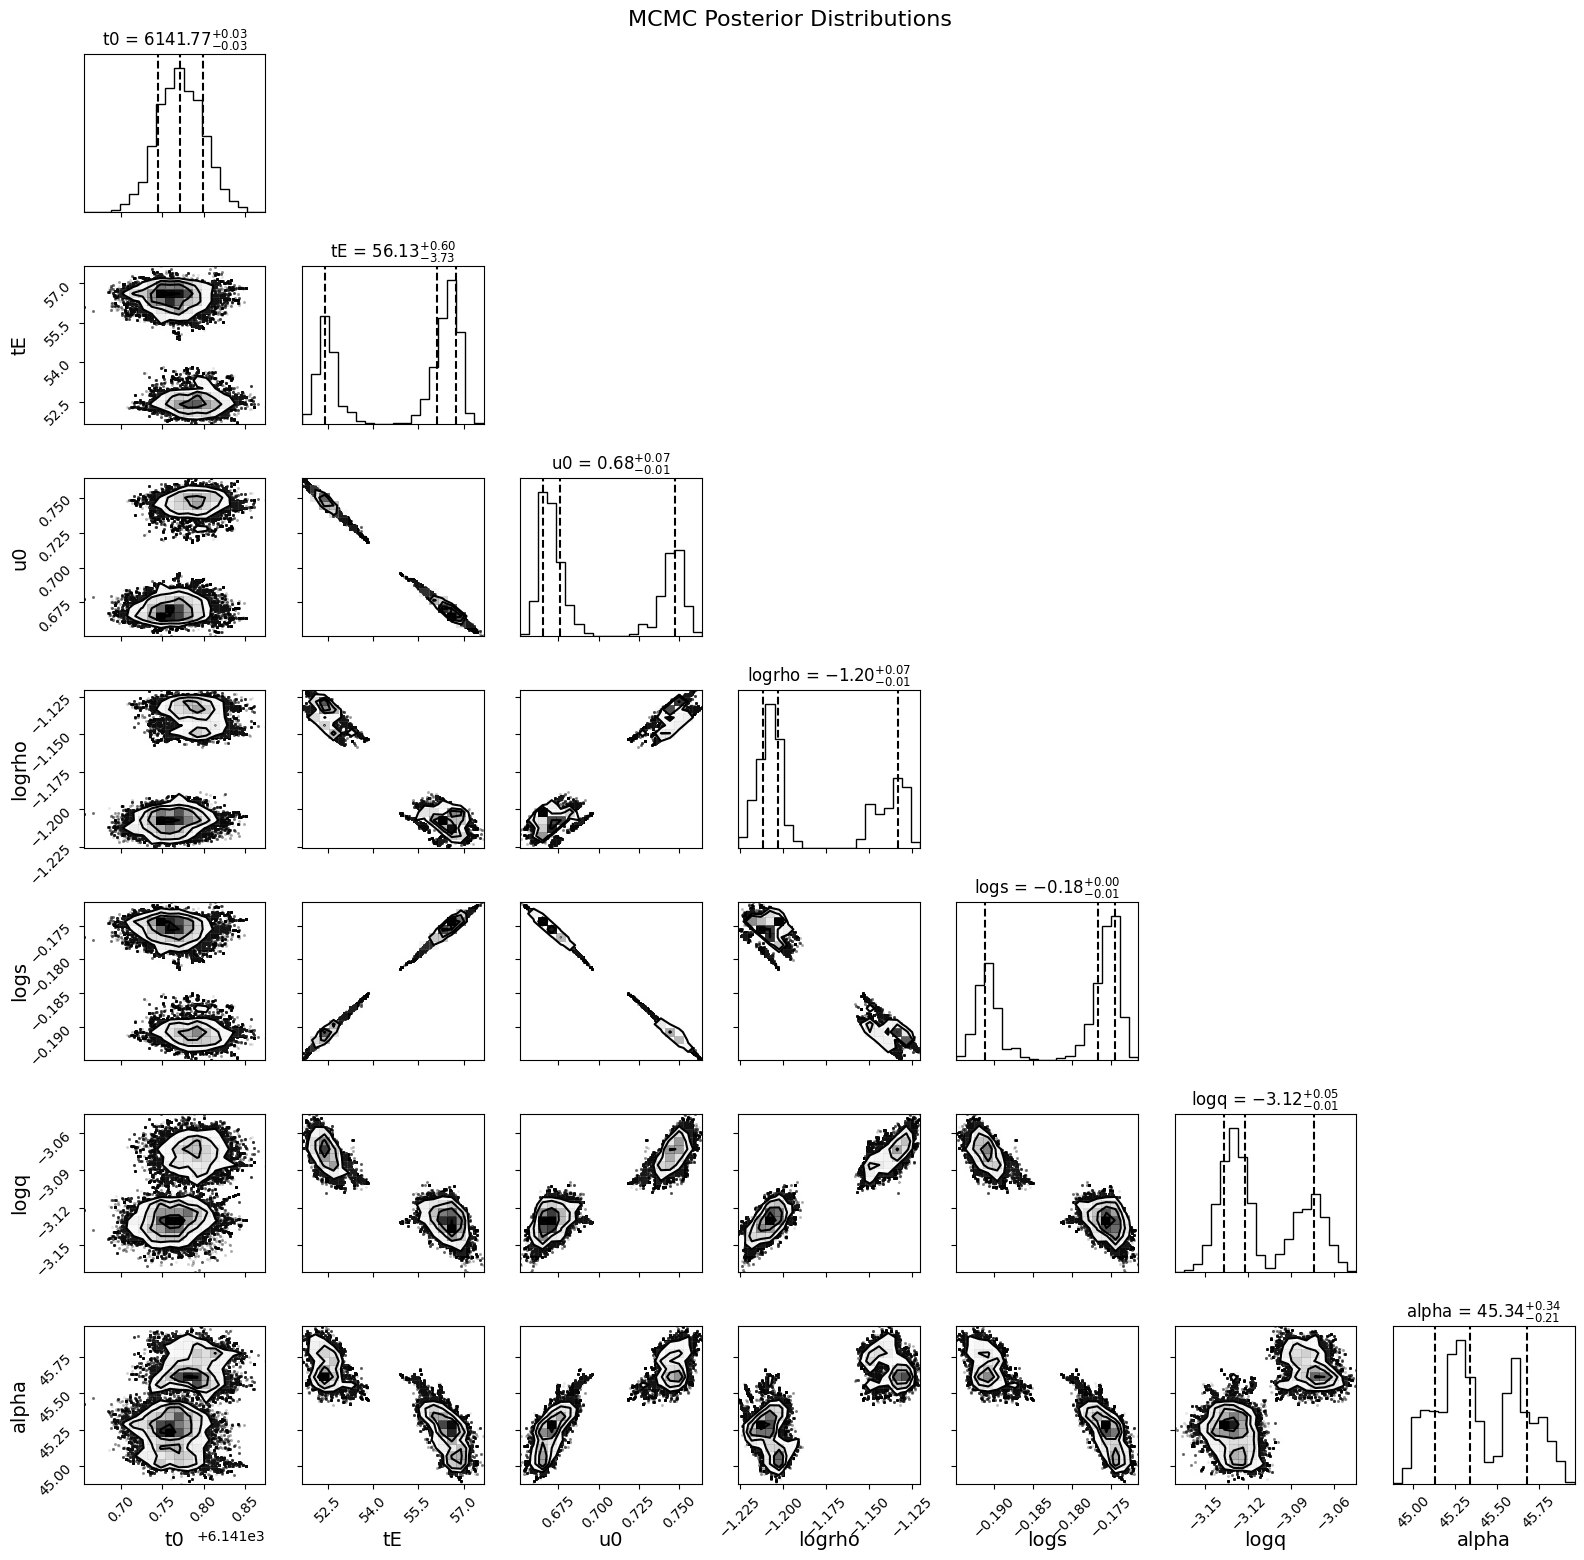

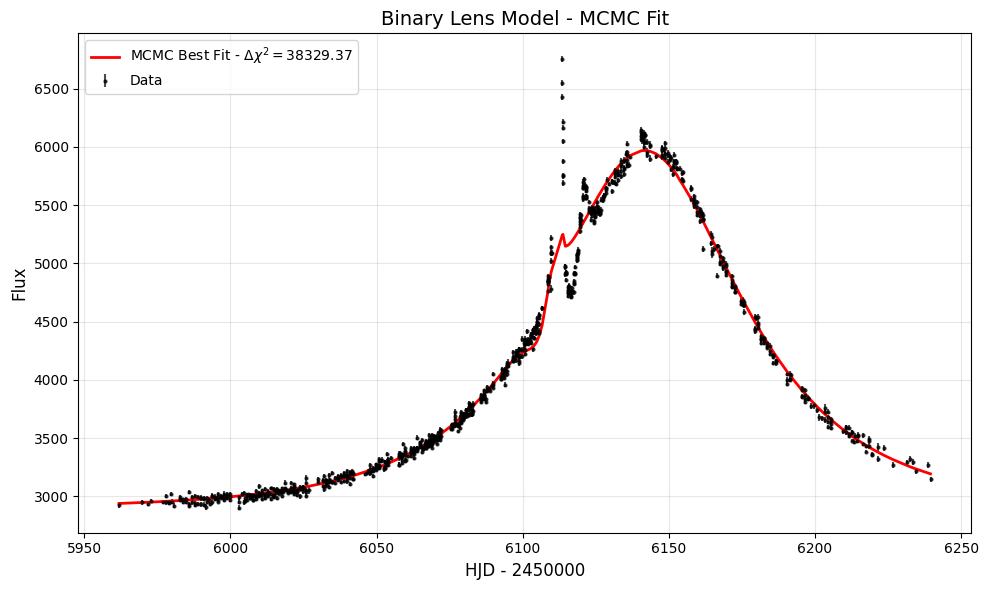

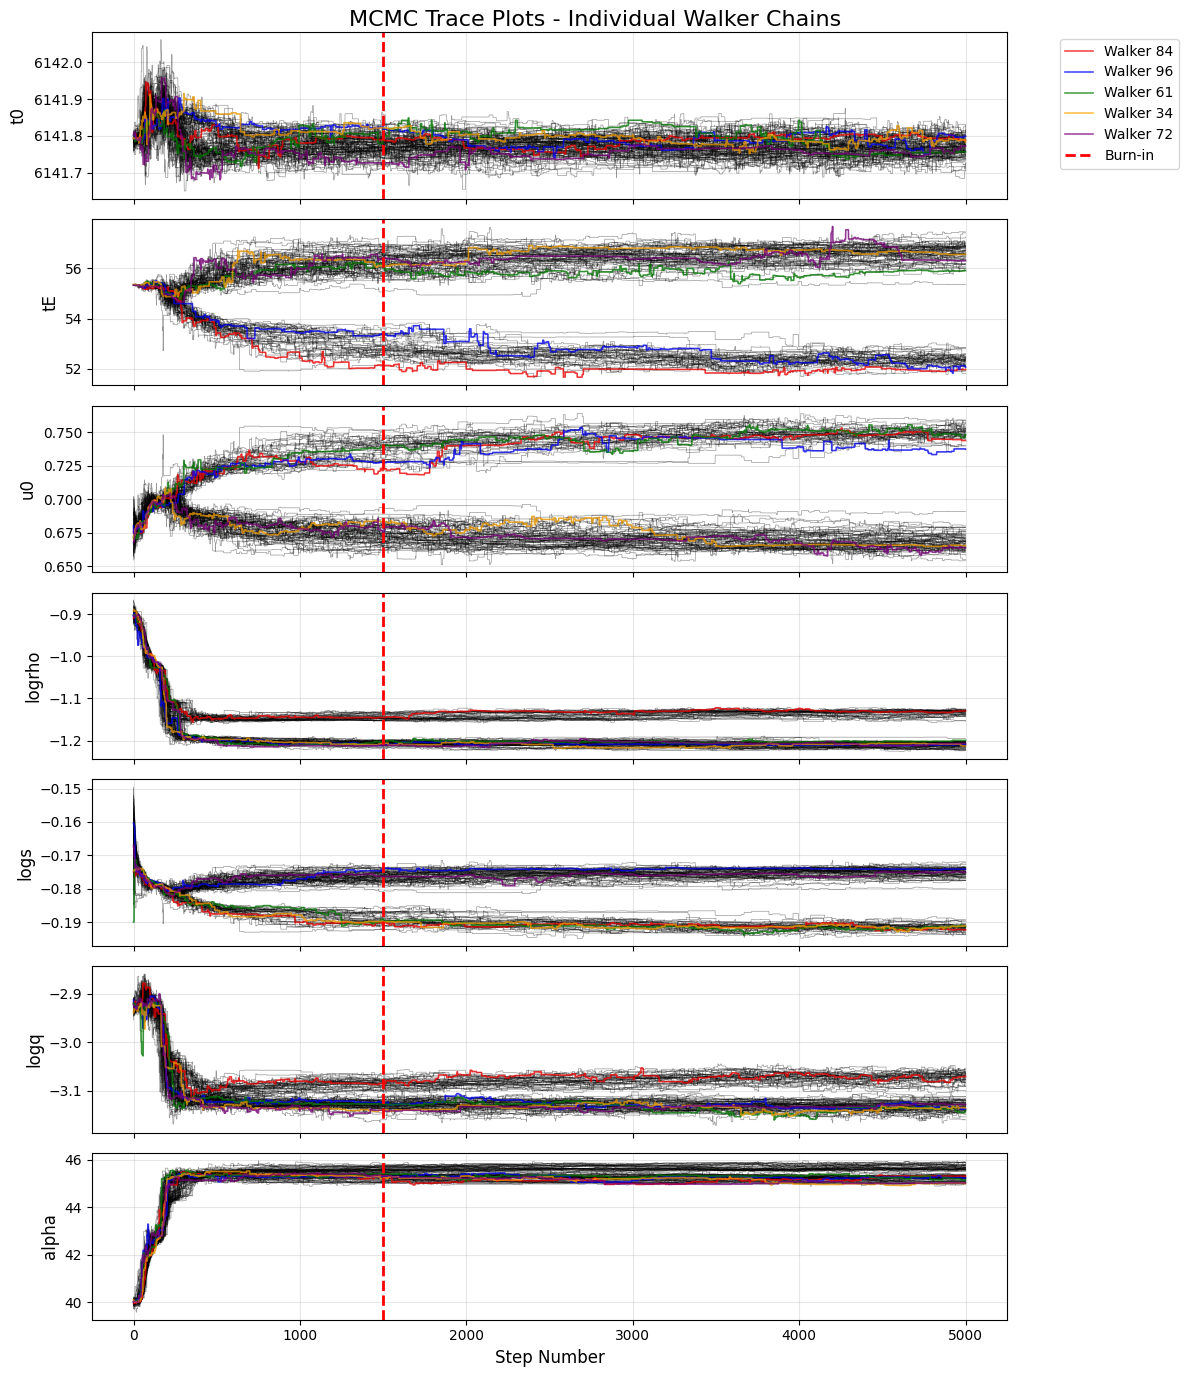

In [ ]:
#run MCMC on two best solutions to find final refined solutions

x0 = np.array([results['sorted_results'][0]['all_params']['t0'], results['sorted_results'][0]['all_params']['tE'], results['sorted_results'][0]['all_params']['u0'], results['sorted_results'][0]['all_params']['logrho'], results['sorted_results'][0]['all_params']['logs'], results['sorted_results'][0]['all_params']['logq'], results['sorted_results'][0]['all_params']['alpha']])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']

# Run MCMC analysis with all plots enabled
results_final = perform_mcmc_analysis(df, x0, p, steps=5000, walkers=100, param_scales=np.array([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-1]),
                               verbose=False, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False, bounds={'u0': (-4, 4), 'logrho': (-4, -0.5), 'logq':(-4, -2), 'logs':(-0.4, 0.3)})

In [18]:
#run MCMC on 3rd best solution
x0 = np.array([results['sorted_results'][2]['all_params']['t0'], results['sorted_results'][2]['all_params']['tE'], results['sorted_results'][2]['all_params']['u0'], results['sorted_results'][2]['all_params']['logrho'], results['sorted_results'][2]['all_params']['logs'], results['sorted_results'][2]['all_params']['logq'], results['sorted_results'][2]['all_params']['alpha']])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']
results = perform_mcmc_analysis(df, x0, p, steps=5000, walkers=100, param_scales=np.array([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-1]),
                               verbose=False, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False, bounds={'u0': (-4, 4), 'logrho': (-4, -0.5), 'logq':(-4, -2), 'logs':(-0.4, 0.3)})




KeyError: 'sorted_results'

Write code to calculate maginification maps for any s, q, $\rho$

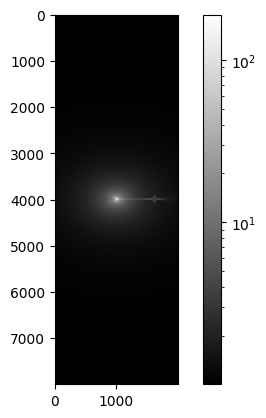

In [48]:
#plot the magnification map in greyscale in log scale
#read the fits file
mag_map = fits.getdata('magmap_test.fits')
fig, ax = plt.subplots()
plt.imshow(mag_map[:, 3000:5000], cmap='gray', norm='log')
plt.colorbar()
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ratio = 3./1.
ax.set_aspect(abs((x_right - x_left) / (y_high - y_low))*ratio)
plt.show()